Stroke prediction based on Kaggle Dataset. 
Comparison of different Algorithms.


# Import Libraries


In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import plotly.express as px

import matplotlib.pyplot as plt

In [2]:
from sklearn.model_selection import train_test_split, cross_val_score, cross_validate, GridSearchCV, RandomizedSearchCV
from sklearn.pipeline import Pipeline
from sklearn.impute import KNNImputer
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler, OrdinalEncoder, OneHotEncoder

from sklearn.compose import ColumnTransformer
from sklearn.metrics import classification_report, confusion_matrix

In [3]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC

In [4]:
import warnings
warnings.filterwarnings("ignore")

In [5]:
# save figs

from pathlib import Path

IMAGES_PATH = Path() / "images" 
IMAGES_PATH.mkdir(parents=True, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = IMAGES_PATH / f"{fig_id}.{fig_extension}"
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

# Data Loading

In [6]:
df = pd.read_csv('healthcare-dataset-stroke-data.csv', delimiter=',')
df.head()

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,9046,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
1,51676,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,NaN,never smoked,1
2,31112,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
3,60182,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
4,1665,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1


# Data cleaning

## First look at data

In [7]:
# check for null values
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5110 entries, 0 to 5109
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   id                 5110 non-null   int64  
 1   gender             5110 non-null   object 
 2   age                5110 non-null   float64
 3   hypertension       5110 non-null   int64  
 4   heart_disease      5110 non-null   int64  
 5   ever_married       5110 non-null   object 
 6   work_type          5110 non-null   object 
 7   Residence_type     5110 non-null   object 
 8   avg_glucose_level  5110 non-null   float64
 9   bmi                4909 non-null   float64
 10  smoking_status     5110 non-null   object 
 11  stroke             5110 non-null   int64  
dtypes: float64(3), int64(4), object(5)
memory usage: 479.2+ KB


In [8]:
df.describe(include='all')

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
count,5110.000000,5110,5110.000000,5110.000000,5110.000000,5110,5110,5110,5110.000000,4909.000000,5110,5110.000000
unique,NaN,3,NaN,NaN,NaN,2,5,2,NaN,NaN,4,NaN
top,NaN,Female,NaN,NaN,NaN,Yes,Private,Urban,NaN,NaN,never smoked,NaN
freq,NaN,2994,NaN,NaN,NaN,3353,2925,2596,NaN,NaN,1892,NaN
mean,36517.829354,NaN,43.226614,0.097456,0.054012,NaN,NaN,NaN,106.147677,28.893237,NaN,0.048728
std,21161.721625,NaN,22.612647,0.296607,0.226063,NaN,NaN,NaN,45.283560,7.854067,NaN,0.215320
min,67.000000,NaN,0.080000,0.000000,0.000000,NaN,NaN,NaN,55.120000,10.300000,NaN,0.000000
25%,17741.250000,NaN,25.000000,0.000000,0.000000,NaN,NaN,NaN,77.245000,23.500000,NaN,0.000000
50%,36932.000000,NaN,45.000000,0.000000,0.000000,NaN,NaN,NaN,91.885000,28.100000,NaN,0.000000
75%,54682.000000,NaN,61.000000,0.000000,0.000000,NaN,NaN,NaN,114.090000,33.100000,NaN,0.000000


note

- lowest bmi value (10.3) seems odd (maybe children?)
- mean of 0/1 encoded stroke feature indicates imbalanced dataset
- min. age is < 1 year --> need to decide if age related stroke prediction differs from general stroke pred as impact factors are likely to differ


In [9]:
# check stroke occurences for younger people
df.loc[(df['stroke']!=1) & (df['age']<=30)]

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
249,30669,Male,3.00,0,0,No,children,Rural,95.12,18.0,Unknown,0
251,16523,Female,8.00,0,0,No,Private,Urban,110.89,17.6,Unknown,0
253,46136,Male,14.00,0,0,No,Never_worked,Rural,161.28,19.1,Unknown,0
265,19584,Female,20.00,0,0,No,Private,Urban,84.62,19.7,smokes,0
274,70336,Female,25.00,0,0,Yes,Private,Urban,60.84,24.5,never smoked,0
...,...,...,...,...,...,...,...,...,...,...,...,...
5094,28048,Male,13.00,0,0,No,children,Urban,82.38,24.3,Unknown,0
5095,68598,Male,1.08,0,0,No,children,Rural,79.15,17.4,Unknown,0
5098,579,Male,9.00,0,0,No,children,Urban,71.88,17.5,Unknown,0
5103,22127,Female,18.00,0,0,No,Private,Urban,82.85,46.9,Unknown,0


In [10]:
# approx. 13% children in dataset

round(df.work_type.value_counts(normalize=True)*100,2)

Private          57.24
Self-employed    16.03
children         13.44
Govt_job         12.86
Never_worked      0.43
Name: work_type, dtype: float64

In [11]:
# check if all children (age <18) have 'children' as work type

df.loc[(df['work_type']!='children') & (df['age']<18)]

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
251,16523,Female,8.0,0,0,No,Private,Urban,110.89,17.6,Unknown,0
253,46136,Male,14.0,0,0,No,Never_worked,Rural,161.28,19.1,Unknown,0
284,26325,Male,14.0,0,0,No,Govt_job,Urban,82.34,31.6,Unknown,0
288,70970,Female,17.0,0,0,No,Self-employed,Urban,82.18,23.4,Unknown,0
395,23462,Female,17.0,0,0,No,Private,Urban,87.52,39.2,never smoked,0
...,...,...,...,...,...,...,...,...,...,...,...,...
4950,66650,Female,17.0,0,0,No,Private,Urban,68.86,41.1,never smoked,0
4981,61801,Male,15.0,0,0,No,Private,Urban,65.05,24.6,Unknown,0
5003,63158,Male,17.0,0,0,No,Private,Urban,63.28,40.2,Unknown,0
5004,27435,Female,17.0,0,0,No,Private,Urban,82.64,31.1,Unknown,0


need to decide what to do with data points. leaving data of children in might also skew the data, see smoking status 'unknown'.

In [12]:
round(df.smoking_status.value_counts(normalize=True)*100,2)

never smoked       37.03
Unknown            30.22
formerly smoked    17.32
smokes             15.44
Name: smoking_status, dtype: float64

In [13]:
# age has highest correlation, also multicorrelation present as other features correlate with age
df.corr()

,id,age,hypertension,heart_disease,avg_glucose_level,bmi,stroke
id,1.000000,0.003538,0.003550,-0.001296,0.001092,0.003084,0.006388
age,0.003538,1.000000,0.276398,0.263796,0.238171,0.333398,0.245257
hypertension,0.003550,0.276398,1.000000,0.108306,0.174474,0.167811,0.127904
heart_disease,-0.001296,0.263796,0.108306,1.000000,0.161857,0.041357,0.134914
avg_glucose_level,0.001092,0.238171,0.174474,0.161857,1.000000,0.175502,0.131945
bmi,0.003084,0.333398,0.167811,0.041357,0.175502,1.000000,0.042374
stroke,0.006388,0.245257,0.127904,0.134914,0.131945,0.042374,1.000000


## Plot data

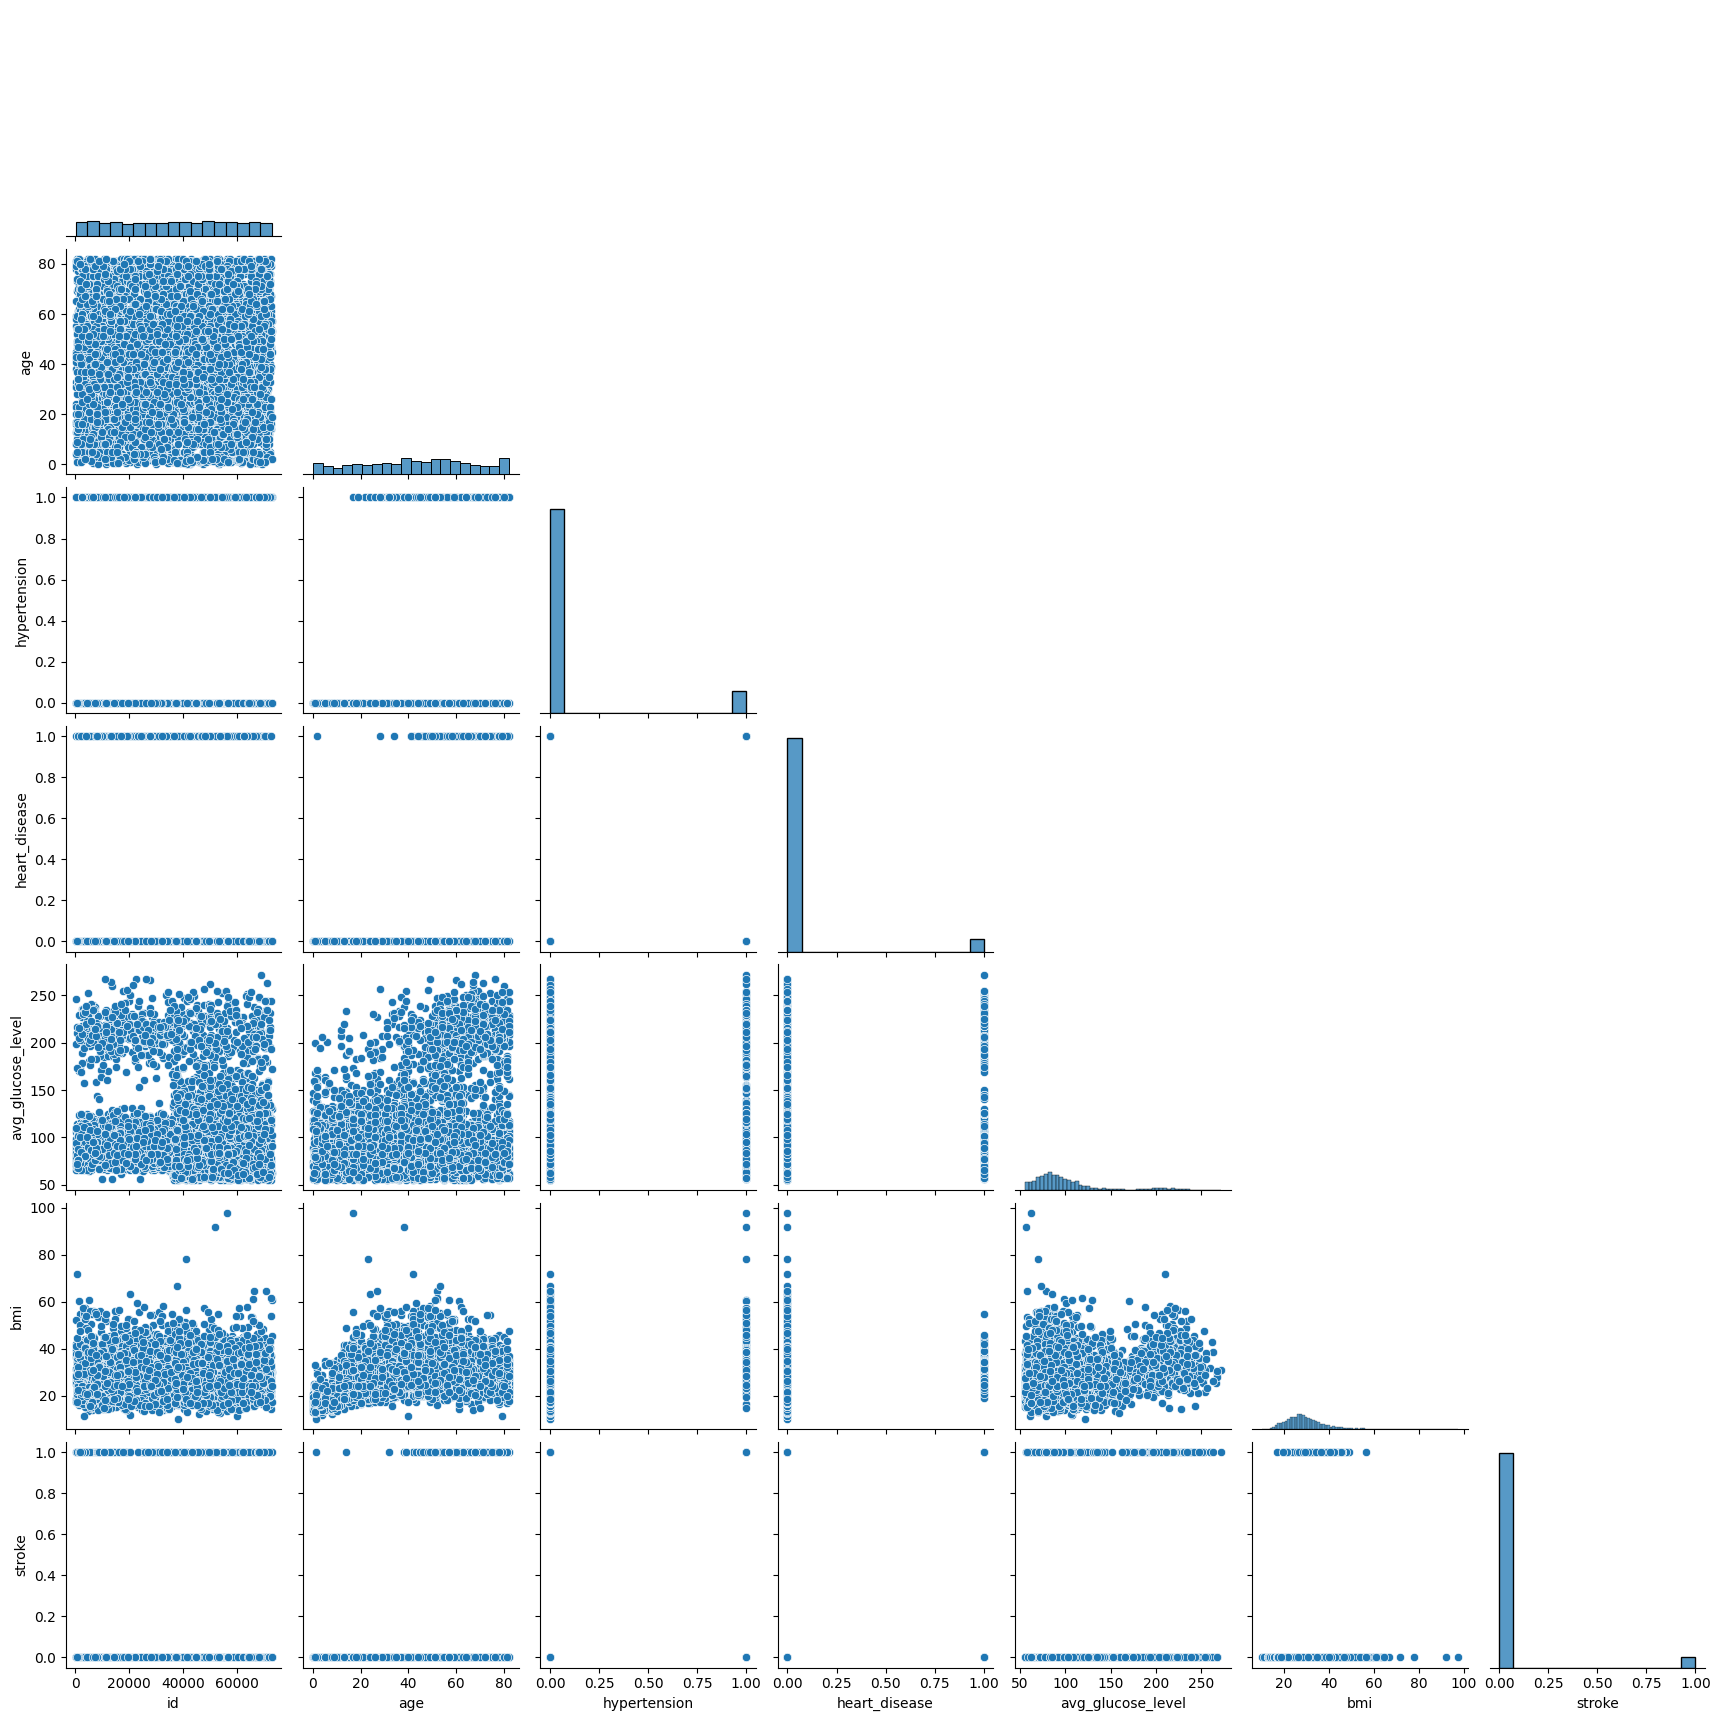

In [14]:
sns.pairplot(data=df,corner=True)

- stroke cases mostly in higher age
- seems to be a correlation between age and bmi
- seems to be a correlation between age and glucose level

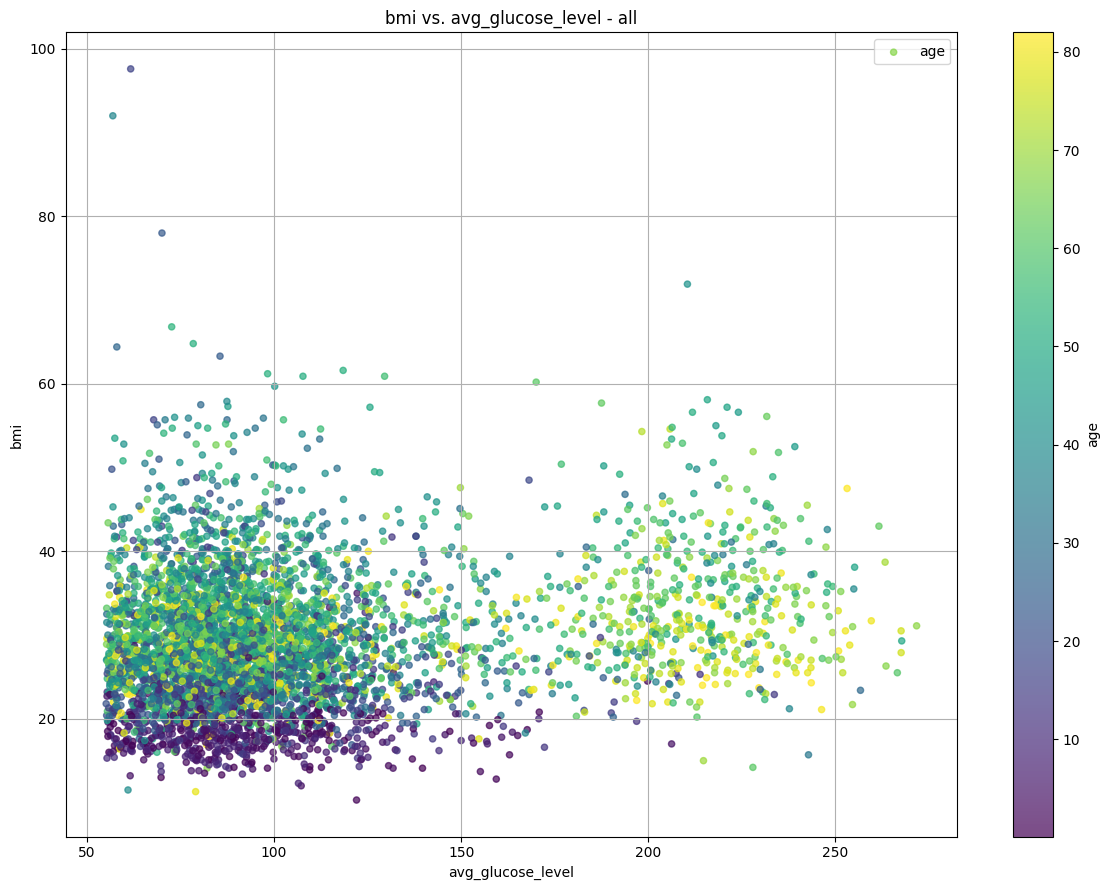

In [15]:
# two clusters

df.plot(kind="scatter", y="bmi", x="avg_glucose_level", grid=True,
              label="age",
             c="age", cmap="jet", colorbar=True,
             legend=True, figsize=(12, 9)
             , sharex=False, alpha=0.7, title='bmi vs. avg_glucose_level - all'
            )
save_fig("scatter_glucose_bmi_all")  # extra code
plt.show()

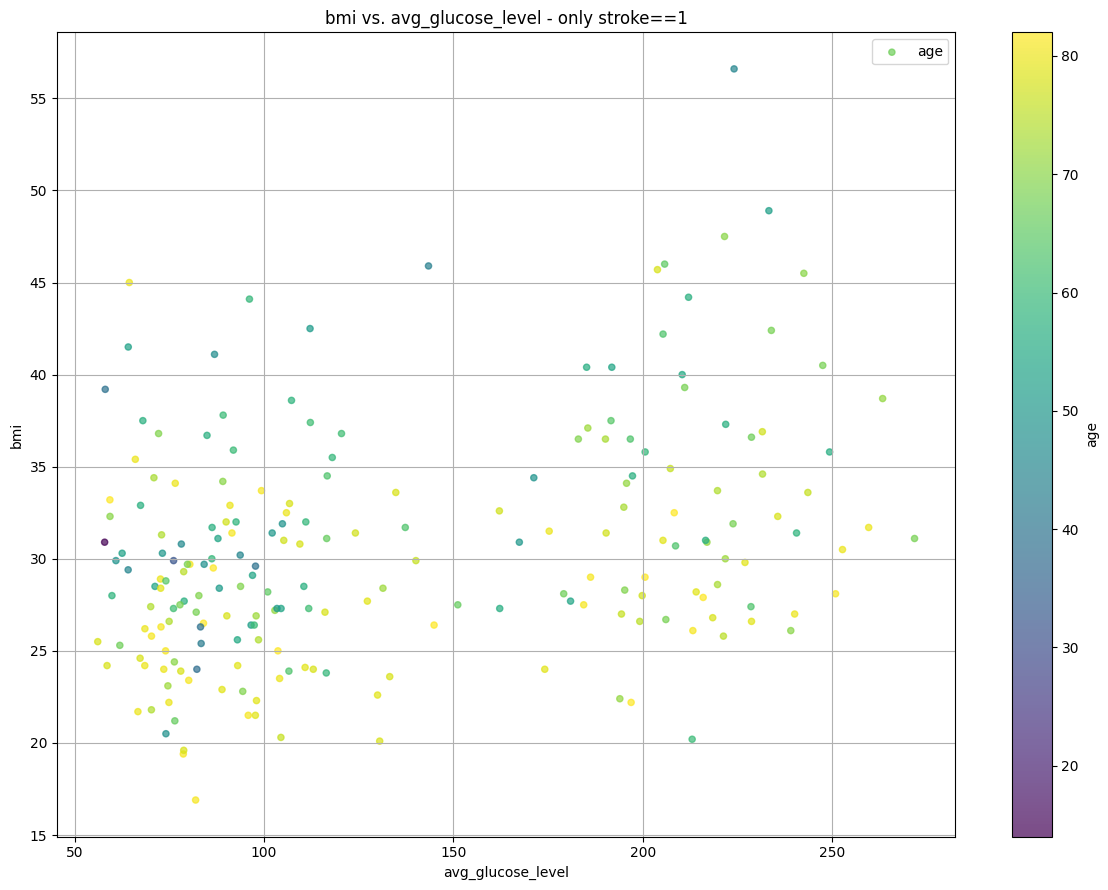

In [16]:
# same

df_stroke = df.loc[df['stroke'] == 1]
df_stroke.plot(kind="scatter", y="bmi", x="avg_glucose_level", grid=True,
              label="age",
             c="age", cmap="jet", colorbar=True,
             legend=True, figsize=(12, 9)
             , sharex=False, alpha=0.7,
               title='bmi vs. avg_glucose_level - only stroke==1'
            )
save_fig("scatter_glucose_bmi_stroke == 1")  
plt.show()

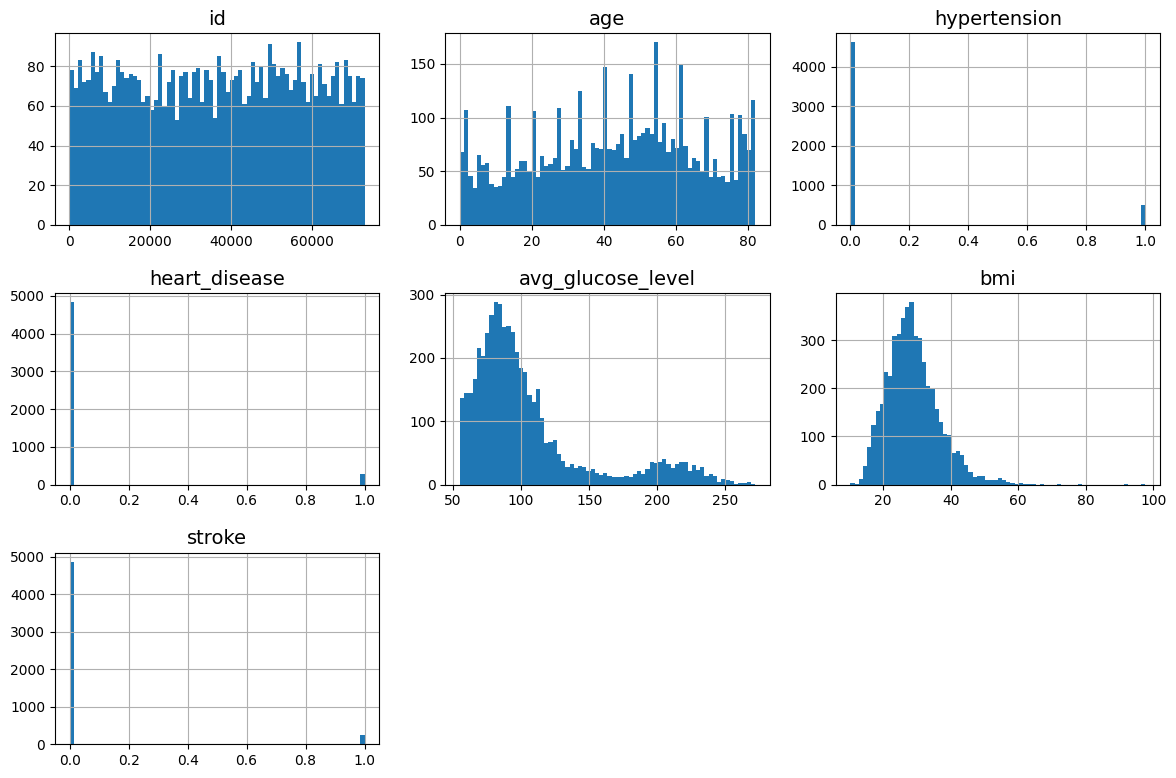

In [17]:
# histogram
plt.rc('font', size=14)
plt.rc('axes', labelsize=14, titlesize=14)
plt.rc('legend', fontsize=14)
plt.rc('xtick', labelsize=10)
plt.rc('ytick', labelsize=10)
df.hist(bins=70, figsize=(12, 8))
save_fig("attributs_histogram_plots")  # extra code
plt.show()

- two peaks for glucose level
- some 'outliers' for bmi
- imbalanced data with few stroke==1 data points

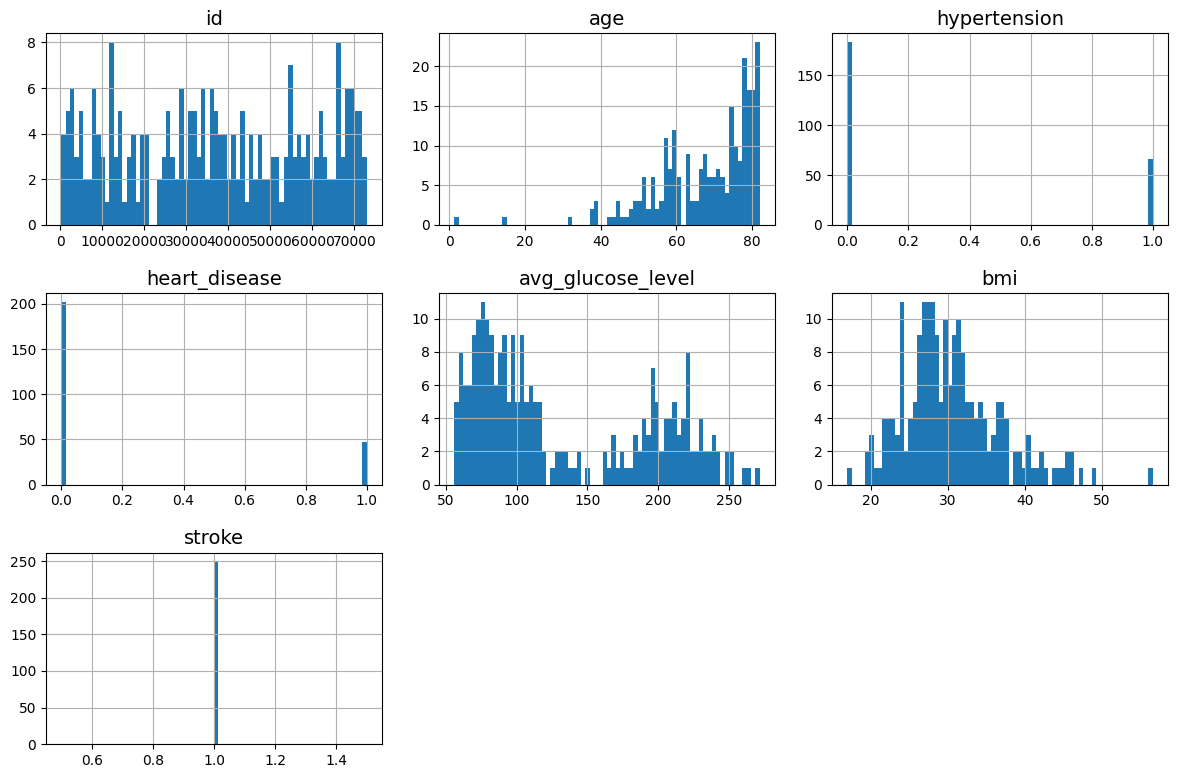

In [18]:
# same only for strokes

df_stroke = df.loc[df['stroke'] == 1]

plt.rc('font', size=14)
plt.rc('axes', labelsize=14, titlesize=14)
plt.rc('legend', fontsize=14)
plt.rc('xtick', labelsize=10)
plt.rc('ytick', labelsize=10)
df_stroke.hist(bins=70, figsize=(12, 8))
save_fig("attribute_histogram_plots_only_stroke==1")  # extra code
plt.show()

**Based on initial viewing and some researching on risk factors of strokes**

- Smokers have an increased risk of suffering a stroke
- The older a person is, the higher their risk of having a stroke
- People with high blood pressure have an increased risk of having a stroke
- People with heart disease have an increased risk of having a stroke
- People with high glucose levels have an increased risk of stroke
- Individuals with a high BMI have an increased risk of having a stroke
- Age is the highest influencing factor 

## Remove rows

Removing entries of peope < 40 reduces dataset immensely but ensures that only age related stroke is considered.

In [19]:
df = df.loc[df['age']>=40,:]

## Remove columns

In [20]:
# delete columns that won't be used for prediction
df.drop("id",inplace=True,axis=1)

In [21]:
pd.crosstab(df['Residence_type'],df['stroke'])

stroke,0,1
Residence_type,,
Rural,1330,110
Urban,1369,131


In [22]:
# remove residence_type and ever_married as assumped that influence is minimal
df.drop(columns=['Residence_type','ever_married'],inplace=True)

# Pre-process data

In [23]:
# imbalanced data with only approx. 8% stroke cases
df['stroke'].value_counts(normalize=True)

0    0.918027
1    0.081973
Name: stroke, dtype: float64

## Stratified train test split

In [24]:
X_Train, X_Test = train_test_split(
    df, test_size=0.25, stratify=df[['stroke']], 
    random_state=42)

X_Test.head()

,gender,age,hypertension,heart_disease,work_type,avg_glucose_level,bmi,smoking_status,stroke
3375,Female,53.0,0,0,Private,227.68,NaN,never smoked,0
4437,Female,66.0,0,0,Self-employed,212.92,21.4,never smoked,0
4371,Female,44.0,0,0,Govt_job,108.38,27.7,Unknown,0
2500,Female,59.0,0,0,Self-employed,55.46,20.9,never smoked,0
5045,Female,44.0,0,0,Private,98.30,25.0,never smoked,0


In [25]:
# Create labels

y_train = X_Train.iloc[:, -1:]
X_Train = X_Train.iloc[:, 0:8]
y_test = X_Test.iloc[:, -1:]
X_Test = X_Test.iloc[:, 0:8]

In [26]:
# df with numeric values

numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
X_Train_num = X_Train.select_dtypes(include=numerics)
X_Train_num

,age,hypertension,heart_disease,avg_glucose_level,bmi
4122,57.0,0,0,111.08,27.9
2096,65.0,0,0,197.69,28.4
1881,62.0,0,0,130.56,36.1
2087,42.0,0,0,98.76,26.4
2527,78.0,0,1,145.03,26.8
...,...,...,...,...,...
3169,56.0,0,0,78.93,31.1
3161,42.0,0,0,177.91,NaN
191,51.0,1,0,112.16,42.5
3821,64.0,1,0,57.42,28.0


In [27]:
# dataframe with categorical features

X_Train_cat = X_Train.select_dtypes(include=['object', 'category'])
X_Train_cat

,gender,work_type,smoking_status
4122,Male,Private,never smoked
2096,Male,Private,smokes
1881,Male,Self-employed,Unknown
2087,Female,Self-employed,smokes
2527,Male,Private,formerly smoked
...,...,...,...
3169,Male,Private,Unknown
3161,Male,Private,Unknown
191,Male,Private,formerly smoked
3821,Male,Private,smokes


## Pipeline for numerical values

In [28]:
num_pipeline = Pipeline([
        # imputer
        ('knn_imputer', KNNImputer(n_neighbors=2)),
    
        # scaler
        ('std_scaler', StandardScaler()),
        # ('minmax_scaler', MinMaxScaler()),
        # ('robus_scaler', RobustScaler())
    ])

## Column Transformer

In [29]:
num_attribs = list(X_Train_num)
cat_onehot = ['work_type','gender']
cat_ordinal = ['smoking_status']

transform_pipeline = ColumnTransformer([
        # num pipeline
        ("num", num_pipeline, num_attribs),   

        # encoder
         ('onehot', 
          OneHotEncoder(handle_unknown='error',
                                  sparse=False, 
                                  drop='if_binary', 
                                  dtype=int),
          cat_onehot
         ),
         ('ordinal', 
          OrdinalEncoder(categories=[['never smoked','formerly smoked','smokes','Unknown']],
                         handle_unknown='error'),
          cat_ordinal
         )
    ])

X_Train_prepared = transform_pipeline.fit(X_Train)
X_Train_prepared = transform_pipeline.transform(X_Train)

In [30]:
# Check
X_Train_prepared_df = pd.DataFrame(X_Train_prepared)
X_Train_prepared_df.head(10)

,0,1,2,3,4,5,6,7,8,9
0,-0.206945,-0.422509,-0.329541,-0.044952,-0.435488,0.0,1.0,0.0,1.0,0.0
1,0.438478,-0.422509,-0.329541,1.636118,-0.363148,0.0,1.0,0.0,1.0,2.0
2,0.196444,-0.422509,-0.329541,0.333148,0.750891,0.0,0.0,1.0,1.0,3.0
3,-1.417113,-0.422509,-0.329541,-0.284079,-0.652508,0.0,0.0,1.0,0.0,2.0
4,1.487290,-0.422509,3.034524,0.614006,-0.594636,0.0,1.0,0.0,1.0,1.0
5,-0.933046,-0.422509,-0.329541,-0.446732,1.025783,0.0,0.0,1.0,0.0,2.0
6,0.438478,-0.422509,-0.329541,-0.477011,-0.392084,0.0,1.0,0.0,0.0,1.0
7,1.567968,-0.422509,-0.329541,-0.576388,-0.319743,0.0,0.0,1.0,0.0,0.0
8,-1.175080,2.366811,-0.329541,-0.356671,-0.789954,1.0,0.0,0.0,0.0,2.0
9,-0.691012,-0.422509,-0.329541,-0.731083,-0.030383,0.0,0.0,1.0,1.0,0.0


## KNN Imputer on column 'smoking status'

In [31]:
imputer = KNNImputer(n_neighbors=2, missing_values=3.0)

In [32]:
#check

X_Train_prepared_df = pd.DataFrame(X_Train_prepared)
X_Train_prepared_df.head(10)

,0,1,2,3,4,5,6,7,8,9
0,-0.206945,-0.422509,-0.329541,-0.044952,-0.435488,0.0,1.0,0.0,1.0,0.0
1,0.438478,-0.422509,-0.329541,1.636118,-0.363148,0.0,1.0,0.0,1.0,2.0
2,0.196444,-0.422509,-0.329541,0.333148,0.750891,0.0,0.0,1.0,1.0,3.0
3,-1.417113,-0.422509,-0.329541,-0.284079,-0.652508,0.0,0.0,1.0,0.0,2.0
4,1.487290,-0.422509,3.034524,0.614006,-0.594636,0.0,1.0,0.0,1.0,1.0
5,-0.933046,-0.422509,-0.329541,-0.446732,1.025783,0.0,0.0,1.0,0.0,2.0
6,0.438478,-0.422509,-0.329541,-0.477011,-0.392084,0.0,1.0,0.0,0.0,1.0
7,1.567968,-0.422509,-0.329541,-0.576388,-0.319743,0.0,0.0,1.0,0.0,0.0
8,-1.175080,2.366811,-0.329541,-0.356671,-0.789954,1.0,0.0,0.0,0.0,2.0
9,-0.691012,-0.422509,-0.329541,-0.731083,-0.030383,0.0,0.0,1.0,1.0,0.0


In [33]:
# transform X_Test
X_Test_prepared = transform_pipeline.transform(X_Test)

In [34]:
X_train = X_Train_prepared.copy()
X_test = X_Test_prepared.copy()

# Models

In [35]:
# List of Scores
## As the data is imbalanced, accuracy is not a good measure of the quality of a model. 
score_list=['recall', 'accuracy', 'precision', 'balanced_accuracy']
score_list

['recall', 'accuracy', 'precision', 'balanced_accuracy']

In [36]:
# for scores
def print_scores(scores, text):
    print(text)
    print(50 * '_')
    for ww in scores.keys():
        print('key:', ww , '  (mean:', round(scores[ww].mean(),3), ' min:', round(scores[ww].min(),3), ' max:', round(scores[ww].max(),3),')')

In [37]:
# for predictions

def get_test_scores(yTest, yPred):
    tn, fp, fn, tp = confusion_matrix(yTest, yPred).ravel()

    precision_score = round(tp / (tp + fp),3)
    recall_score = round(tp / (tp + fn),3)

    accu = round((tn + tp) / (tn + fp + tp + fn),3)

    sensitivity = round(tp / (tp + fn),3)
    specificity = round(tn / (tn + fp),3)
    bal_accu = round((sensitivity + specificity) / 2, 3)

    print(
        "Test Data Scores: \n Precision score:",
        precision_score,
        "\n Recall score:",
        recall_score,
        "\n Balanced Accuracy score:",
        bal_accu,
        "\n Accuracy score:",
        accu,
        "\n",
    )

    print(classification_report(yTest, yPred))

## MLP Classifier

Overview 

- Very flexible, can represent any distribution
- Required large datasets to perform well

### Baseline MLP Classifier


In [38]:
mlp_base = MLPClassifier(random_state=0)

In [39]:
mlp_base.fit(X_train, y_train)

MLPClassifier(random_state=0)

#### Training scores for Base MLP Classifier Model

In [40]:
train_scores_base_mlp = cross_validate(X=X_train, y=y_train, estimator=mlp_base, scoring=score_list, cv=5)
print_scores(train_scores_base_mlp, 'Train Score for MLP Base Classifier')

Train Score for MLP Base Classifier
__________________________________________________
key: fit_time   (mean: 0.807  min: 0.775  max: 0.847 )
key: score_time   (mean: 0.002  min: 0.002  max: 0.003 )
key: test_recall   (mean: 0.011  min: 0.0  max: 0.028 )
key: test_accuracy   (mean: 0.916  min: 0.912  max: 0.918 )
key: test_precision   (mean: 0.167  min: 0.0  max: 0.5 )
key: test_balanced_accuracy   (mean: 0.504  min: 0.498  max: 0.513 )


#### Test scores for MLP Base Classifier

In [41]:
ypred_mlp_base = mlp_base.predict(X_test)
get_test_scores(y_test, ypred_mlp_base)

Test Data Scores: 
 Precision score: nan 
 Recall score: 0.0 
 Balanced Accuracy score: 0.5 
 Accuracy score: 0.918 

              precision    recall  f1-score   support

           0       0.92      1.00      0.96       675
           1       0.00      0.00      0.00        60

    accuracy                           0.92       735
   macro avg       0.46      0.50      0.48       735
weighted avg       0.84      0.92      0.88       735



**Comment**

As could be expected, the model does not perform well on the data where stroke==1. As the data is imbalanced, the significance of the accuracy score is very low. Due to the type of data, a high recall score is preferred; however, the recall value for stroke prediction is 0. 

### Improved MLP Classifier Model

##### Perform Grid Search

In [42]:
grid_mlp = MLPClassifier(random_state=5, max_iter=600)

param_grid_mlp = [
    {"hidden_layer_sizes": [(120,60,30), (60, 30, 10), (20, 2)],
     "activation": ["relu", "logistic"],
     "solver": ["sgd", "adam"],
     "alpha": [0.05, 0.01, 0.001],
     "learning_rate": ["constant", "adaptive"],
     #"learning_rate_init": [0.0001, 0.001, 0.01]
     },
]

gridsearch_mlp = GridSearchCV(grid_mlp, param_grid_mlp, cv=5, scoring='recall')

In [43]:
gridsearch_mlp.fit(X_train, y_train.values.ravel())
print(gridsearch_mlp.best_score_,
      gridsearch_mlp.best_params_,
      gridsearch_mlp.best_estimator_
      )

0.08828828828828829 {'activation': 'relu', 'alpha': 0.01, 'hidden_layer_sizes': (60, 30, 10), 'learning_rate': 'constant', 'solver': 'adam'} MLPClassifier(alpha=0.01, hidden_layer_sizes=(60, 30, 10), max_iter=600,
              random_state=5)


#### Training scores for Improved MLP Classifier Model

In [44]:
train_scores_mlp = cross_validate(X=X_train, y=y_train.values.ravel(), estimator=gridsearch_mlp, scoring=score_list, cv=5)
print_scores(train_scores_mlp, 'Train Score for MLP Improved Classifier')

Train Score for MLP Improved Classifier
__________________________________________________
key: fit_time   (mean: 544.026  min: 507.208  max: 568.522 )
key: score_time   (mean: 0.003  min: 0.002  max: 0.004 )
key: test_recall   (mean: 0.055  min: 0.0  max: 0.108 )
key: test_accuracy   (mean: 0.882  min: 0.871  max: 0.891 )
key: test_precision   (mean: 0.102  min: 0.0  max: 0.174 )
key: test_balanced_accuracy   (mean: 0.505  min: 0.477  max: 0.531 )


#### Test scores for Base MLP Classifier Model

In [45]:
ypred_mlp_improved = gridsearch_mlp.predict(X_test)
get_test_scores(y_test, ypred_mlp_improved)

Test Data Scores: 
 Precision score: 0.2 
 Recall score: 0.017 
 Balanced Accuracy score: 0.505 
 Accuracy score: 0.914 

              precision    recall  f1-score   support

           0       0.92      0.99      0.96       675
           1       0.20      0.02      0.03        60

    accuracy                           0.91       735
   macro avg       0.56      0.51      0.49       735
weighted avg       0.86      0.91      0.88       735



**Note**

After gridsearch the model performance improved  slightly. However, precision (20%) and recall (2%) score are both very low. Dataset might be too small for model to perform well; further tuning would be needed to improve it.

## Decision Tree Classifier

Overview

- Pro:
    - Feature normalization is not necessary
    - Handles missing values well
- Con
    - Tends to overfit
    - Sensitive to input data
    - Trees have a bias if the data is not balanced

### Decision Tree Classifier Base Model

In [46]:
dt_base_model = DecisionTreeClassifier()

In [47]:
dt_base_model.fit(X_train, y_train)

DecisionTreeClassifier()

#### Train Scores for Decision Tree Base Model 

In [48]:
train_scores_base_dt = cross_validate(X=X_train, y=y_train, estimator=mlp_base, scoring=score_list, cv=5)
print_scores(train_scores_base_dt, 'Train Score for DT Base Classifier')

Train Score for DT Base Classifier
__________________________________________________
key: fit_time   (mean: 0.849  min: 0.809  max: 0.956 )
key: score_time   (mean: 0.003  min: 0.002  max: 0.004 )
key: test_recall   (mean: 0.011  min: 0.0  max: 0.028 )
key: test_accuracy   (mean: 0.916  min: 0.912  max: 0.918 )
key: test_precision   (mean: 0.167  min: 0.0  max: 0.5 )
key: test_balanced_accuracy   (mean: 0.504  min: 0.498  max: 0.513 )


#### Test Scores for Decision Tree Base Model 

In [49]:
ypred_dt_base = dt_base_model.predict(X_test)
get_test_scores(y_test, ypred_dt_base)

Test Data Scores: 
 Precision score: 0.116 
 Recall score: 0.133 
 Balanced Accuracy score: 0.522 
 Accuracy score: 0.846 

              precision    recall  f1-score   support

           0       0.92      0.91      0.92       675
           1       0.12      0.13      0.12        60

    accuracy                           0.85       735
   macro avg       0.52      0.52      0.52       735
weighted avg       0.86      0.85      0.85       735



**Note**

Classification of stroke cases is poor with both a low precision (15%) and a low recall (18%) value. So far, model performed better and seems more promising than MLP Classifier. 

### Improved Decision Tree Classifier Model

##### Perform Grid Search

In [50]:
# set class weight to 'balanced' to account for imbalanced dataset
grid_dt = DecisionTreeClassifier(class_weight='balanced', random_state=42)

param_grid_dt = {'max_depth': [2, 3, 4, 5,  7, 10, 15, 17],
                 'max_features' : [2, 3, 4, 6, 12],
                 'min_samples_split' : [2, 3, 15, 16, 18, 19, 22, 25]
                }

# Folds for model
dt_cv=5

gridsearch_dt = GridSearchCV(grid_dt, param_grid_dt, cv=dt_cv, scoring='recall')


In [51]:
gridsearch_dt.fit(X_train, y_train.values.ravel())
print(gridsearch_dt.best_score_,
      gridsearch_dt.best_params_,
      gridsearch_dt.best_estimator_
      )

0.816966966966967 {'max_depth': 2, 'max_features': 12, 'min_samples_split': 2} DecisionTreeClassifier(class_weight='balanced', max_depth=2, max_features=12,
                       random_state=42)


#### Training scores for Improved DT Classifier Model


In [52]:
train_scores_dt = cross_validate(X=X_train, y=y_train, estimator=gridsearch_dt, scoring=score_list, cv=5)
print_scores(train_scores_dt, 'Train Score for DT Improved Classifier')

Train Score for DT Improved Classifier
__________________________________________________
key: fit_time   (mean: 4.406  min: 4.362  max: 4.535 )
key: score_time   (mean: 0.002  min: 0.002  max: 0.002 )
key: test_recall   (mean: 0.834  min: 0.639  max: 0.946 )
key: test_accuracy   (mean: 0.539  min: 0.463  max: 0.671 )
key: test_precision   (mean: 0.134  min: 0.118  max: 0.153 )
key: test_balanced_accuracy   (mean: 0.673  min: 0.644  max: 0.733 )


#### Test scores for Improved DT Classifier Model


In [53]:
ypred_dt_improved = gridsearch_dt.predict(X_test)
get_test_scores(y_test, ypred_dt_improved)

Test Data Scores: 
 Precision score: 0.124 
 Recall score: 0.867 
 Balanced Accuracy score: 0.661 
 Accuracy score: 0.488 

              precision    recall  f1-score   support

           0       0.97      0.45      0.62       675
           1       0.12      0.87      0.22        60

    accuracy                           0.49       735
   macro avg       0.55      0.66      0.42       735
weighted avg       0.91      0.49      0.59       735



**Notes Decision Tree**

Recall value of stroke cases could be improved significantly (87%). However, precision dropped slightly (from 15% down to 12%) as well as the recall value for the non-stroke entries. Comparing the training and test data reveals that no overfitting is present.

## Support Vector Classifier Model

SVMS

SVC is a versatile algorithm that can achieve high accuracy even with relatively small training data. Since SVCs define the best separation level between classes, they are mostly well generalizable (perform well not only on training data but also on test data). They are also relatively memory efficient; however, it does not perform well on imbalanced data. SVC finds a hyperplane decision boundary that, in this example, divides the data into two classes. The boundary of the classes can use a 'margin', which allows some points to be misclassified.

Overview

- Performs best 
    - with higher dimensions, many features/columns
    - If classes are separable (linear or non-linear)
- Pro
    - Outlier have no big influence
- Con
    - Slow with large data sets
    - Poor performance when classes overlap
    - Hyperparameter selection is necessary to ensure generalization
    - Finding the right kernel function requires expertise
    - Prefers majority class on imbalanced data

##### Perform Grid Search

In [54]:
# set class weight to 'balanced' to account for imbalanced dataset
grid_svc = SVC(random_state=42)

param_grid_svc = {'C':[0.1,0.5,1,10,100,1000],
                  'gamma':[1,0.1,0.01,0.001,0.0001],
                  'class_weight': ['balanced',{0:100,1:1}, {0:10,1:1}, {0:1,1:1}, {0:1,1:10}, {0:1,1:100}]
                 }

# Folds for model
svc_cv=5



In [55]:
gridsearch_svc = GridSearchCV(grid_svc, param_grid_svc, cv=svc_cv, scoring='recall')

gridsearch_svc.fit(X_train, y_train.values.ravel())
print(gridsearch_svc.best_score_,
      gridsearch_svc.best_params_,
      gridsearch_svc.best_estimator_
      )

1.0 {'C': 0.1, 'class_weight': 'balanced', 'gamma': 0.0001} SVC(C=0.1, class_weight='balanced', gamma=0.0001, random_state=42)


#### Training scores for SVC Classifier Model


In [56]:
train_scores_svc = cross_validate(X=X_train, y=y_train.values.ravel(), estimator=gridsearch_svc, scoring=score_list, cv=5)
print_scores(train_scores_svc, 'Train Score for SVC Classifier')

Train Score for SVC Classifier
__________________________________________________
key: fit_time   (mean: 86.759  min: 81.162  max: 91.819 )
key: score_time   (mean: 0.06  min: 0.058  max: 0.062 )
key: test_recall   (mean: 0.972  min: 0.917  max: 1.0 )
key: test_accuracy   (mean: 0.188  min: 0.084  max: 0.311 )
key: test_precision   (mean: 0.091  min: 0.084  max: 0.101 )
key: test_balanced_accuracy   (mean: 0.545  min: 0.5  max: 0.599 )


#### Test scores for SVC Classifier Model


In [57]:
ypred_svc_improved = gridsearch_svc.predict(X_test)
get_test_scores(y_test, ypred_svc_improved)

Test Data Scores: 
 Precision score: nan 
 Recall score: 0.0 
 Balanced Accuracy score: 0.5 
 Accuracy score: 0.918 

              precision    recall  f1-score   support

           0       0.92      1.00      0.96       675
           1       0.00      0.00      0.00        60

    accuracy                           0.92       735
   macro avg       0.46      0.50      0.48       735
weighted avg       0.84      0.92      0.88       735



**Note**

Model performance improved significantly on training dataset but dropped on test dataset due to overfitting.

Overall, the best model was a weight adjusted decision tree with a recall value of 87%. Next steps for improvement should be a more balanced optimization of recall and precision.